# The Vanishing/Exploding Gradients Problems
This problem occurs when information is lost during backpropagation, i.e. gradients dwindle to nothing or explode as the model diverges. This makes it very difficult to train low layers, as their weights are not being updated properly.

This can generally be solved using a better activation function or initialization (or combination thereof).

## Nonsaturating activation functions
Leaky ReLU implementation - create a leaky ReLU layer just after the layer you want to apply it to

In [1]:
import tensorflow as tf
from tensorflow import keras

model = keras.models.Sequential([
    keras.layers.Dense(10, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(alpha=0.2)
])

SELU activation implementation

In [2]:
layer = keras.layers.Dense(10, activation="selu",
                           kernel_initializer="lecun_normal")

## Batch Normalization
Adds an operation in teh model just before or after the activation function of each hidden layer: zero-center and normalize each input, then scale and shift the result using two new parameter vectors (one for scaling and one for shifting). Lets the model learn the optimal scale and mean of each layer's inputs.

Batch normization has become ubiquitous.

### Implementing batch normalization with keras
This model adds a batch normalization layer before each hidden layer. That's it!

In [3]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [4]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_2 (Dense)              (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_4 (Dense)              (None, 10)               

let's try it on mnist

In [5]:
mnist = keras.datasets.mnist
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()
X_train_full.shape

(60000, 28, 28)

In [6]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [7]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(200, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [8]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 784)               3136      
_________________________________________________________________
dense_5 (Dense)              (None, 200)               157000    
_________________________________________________________________
batch_normalization_4 (Batch (None, 200)               800       
_________________________________________________________________
dense_6 (Dense)              (None, 100)               20100     
_________________________________________________________________
batch_normalization_5 (Batch (None, 100)               400       
_________________________________________________________________
dense_7 (Dense)              (None, 50)               

In [9]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [10]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4269 - accuracy: 0.8758 - val_loss: 0.1960 - val_accuracy: 0.9428
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2061 - accuracy: 0.9387 - val_loss: 0.1459 - val_accuracy: 0.9544
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.1556 - accuracy: 0.9539 - val_loss: 0.1276 - val_accuracy: 0.9600
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.1296 - accuracy: 0.9610 - val_loss: 0.1134 - val_accuracy: 0.9662
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.1116 - accuracy: 0.9656 - val_loss: 0.1073 - val_accuracy: 0.9664
Epoch 6/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0943 - accuracy: 0.9714 - val_loss: 0.1047 - val_accuracy: 0.9690
Epoch 7/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0839 - accuracy: 0.9745 - val_loss: 0.0997 - val_accuracy:

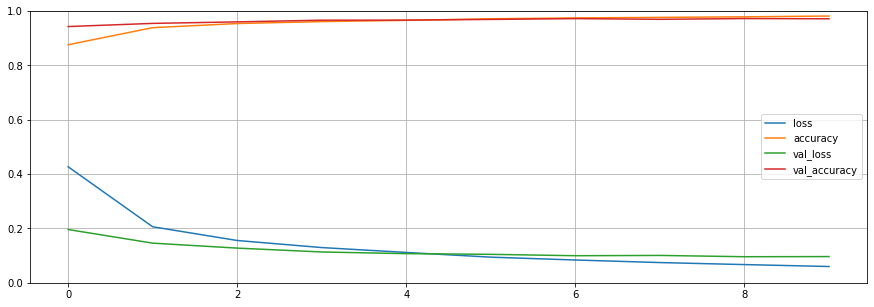

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(15, 5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

the results here are similar to what we saw in chapter 10 without batch norm, but we got to them faster! this is what we expected. if early stopping were implemented here, we should have seen a net drop in wall time.

## Gradient Clipping
Mitigate exploding gradients by limiting gradients during backpropagation so that they don't exceed a threshold. Most often used in recurrent NNs, since batch normalization is tricky with RNNs.

In [12]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="mse", optimizer=optimizer)

can also use ```clipnorm``` instead of ```clipvalue``` to ensure that clipping does not change the direction of the gradient vector.

# Reusing Pretrained Layers
## Transfer learning with Keras
Example trains model A on a subset of mnist fashion (all except sandals and shirts). Uses model A to start model B.

In [13]:
import numpy as np

def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [14]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [15]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [16]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1394/1394 [==============================] - 6s 4ms/step - loss: 0.6960 - accuracy: 0.7886 - val_loss: 0.3815 - val_accuracy: 0.9011
Epoch 2/20
1394/1394 [==============================] - 5s 4ms/step - loss: 0.3493 - accuracy: 0.9004 - val_loss: 0.2907 - val_accuracy: 0.9188
Epoch 3/20
1394/1394 [==============================] - 5s 4ms/step - loss: 0.2910 - accuracy: 0.9152 - val_loss: 0.2543 - val_accuracy: 0.9294
Epoch 4/20
1394/1394 [==============================] - 6s 4ms/step - loss: 0.2616 - accuracy: 0.9242 - val_loss: 0.2331 - val_accuracy: 0.9355
Epoch 5/20
1394/1394 [==============================] - 5s 4ms/step - loss: 0.2423 - accuracy: 0.9293 - val_loss: 0.2195 - val_accuracy: 0.9387
Epoch 6/20
1394/1394 [==============================] - 6s 4ms/step - loss: 0.2283 - accuracy: 0.9333 - val_loss: 0.2083 - val_accuracy: 0.9410
Epoch 7/20
1394/1394 [==============================] - 7s 5ms/step - loss: 0.2168 - accuracy: 0.9371 - val_loss: 0.2000 - val_accuracy:

In [17]:
model_A.save("my_model_A.h5")

In [18]:
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid")) # looking for binary classification (shirt vs sandal)

note that models A and B now share some layers! training model B will impact model A. we need to clone model A to retain it's original weights. (we also have model A saved, so that version will certainly still remain the same too)

In [19]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

when we begin to train model B, the new layer we added will possibly ruin the good layers from model A! since it's weights were randomly initialized, the gradients updated there will be large and could be detrimental lower in the network. let's freeze the lower layers to prevent this.

In [20]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

In [21]:
model_B_on_A.compile(loss="binary_crossentropy", optimizer="sgd",
                     metrics=["accuracy"])

In [22]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 0s 36ms/step - loss: 1.1619 - accuracy: 0.2500 - val_loss: 0.8981 - val_accuracy: 0.4374
Epoch 2/4
7/7 [==============================] - 0s 13ms/step - loss: 0.8353 - accuracy: 0.4750 - val_loss: 0.7179 - val_accuracy: 0.6107
Epoch 3/4
7/7 [==============================] - 0s 16ms/step - loss: 0.6744 - accuracy: 0.6400 - val_loss: 0.6138 - val_accuracy: 0.6770
Epoch 4/4
7/7 [==============================] - 0s 14ms/step - loss: 0.5794 - accuracy: 0.6800 - val_loss: 0.5250 - val_accuracy: 0.7401


now allow all layers to be trained and run for more epochs!

In [23]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

In [24]:
optimizer = keras.optimizers.SGD(lr=1e-4)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])

In [25]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/16
7/7 [==============================] - 0s 52ms/step - loss: 0.5211 - accuracy: 0.7150 - val_loss: 0.5209 - val_accuracy: 0.7444
Epoch 2/16
7/7 [==============================] - 0s 18ms/step - loss: 0.5161 - accuracy: 0.7150 - val_loss: 0.5168 - val_accuracy: 0.7497
Epoch 3/16
7/7 [==============================] - 0s 17ms/step - loss: 0.5113 - accuracy: 0.7150 - val_loss: 0.5125 - val_accuracy: 0.7508
Epoch 4/16
7/7 [==============================] - 0s 18ms/step - loss: 0.5067 - accuracy: 0.7250 - val_loss: 0.5088 - val_accuracy: 0.7572
Epoch 5/16
7/7 [==============================] - 0s 14ms/step - loss: 0.5020 - accuracy: 0.7350 - val_loss: 0.5048 - val_accuracy: 0.7594
Epoch 6/16
7/7 [==============================] - 0s 18ms/step - loss: 0.4974 - accuracy: 0.7550 - val_loss: 0.5013 - val_accuracy: 0.7594
Epoch 7/16
7/7 [==============================] - 0s 17ms/step - loss: 0.4931 - accuracy: 0.7650 - val_loss: 0.4974 - val_accuracy: 0.7636
Epoch 8/16
7/7 [===========

In [26]:
model_B_on_A.evaluate(X_test_B, y_test_B)

58/58 [==============================] - 0s 4ms/step - loss: 17.3405 - accuracy: 0.3562


[17.340518951416016, 0.3562162220478058]

didn't do well at all! if I used the same random seeds as the solutions, I would have gotten a noticeable improvement. the lesson here is that transfer learning isn't always feasible for the network at hand! the solutions note that small dense networks tend to not fare so well with transfer learning since their layers are more specific; compared to a deep CNN, the lower layers in the model above simply aren't as generalizeable or conducive to transfer learning!